# Assignment 4 - CNNs, Residuals, SSL

Class: COMP 5970 - Computer Vision

Author: Chris Hinkson

Email: cmh0201@auburn.edu

*Personal Contribution Statement: This was an individual project and I did everything in it.*

*Generative AI Declaration:* 


### Assignment 4 Table Of Contents

1) 

### Assignment 4 Requirements/Dependencies

requirements/dependencies go here.

### Assignment 4 Citations

As described on the [CIFAR-10 Dataset Webpage](https://www.cs.toronto.edu/~kriz/cifar.html), it is required to cite the following tech report in acknowledgement of the dataset being used:

[Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

### Assignment 4 Report

report goes here

## Environment Preparation

This section will prepare the environment for this assignment by importing dependencies, ensuring project file structure, and downloading datasets.

### Module Import

This section will download needed dependencies for this assignment.

In [ ]:
# System
import gc
import os
import time
import pickle

# Display
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data
from sklearn.metrics import confusion_matrix

# Pytorch Modules
import torch
from torchvision import datasets, transforms

### Cleanup Utility

This section will make a small utility for cleaning up CPU / GPU memory.

In [2]:
def cleanupCpuAndGpu():
    
	# Clear CPU memory
    gc.collect()
    
	# Clear GPU memory if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

### File Structure

This section will ensure that the project has the correct file structure for referencing data/output paths depending on local or colab environment.

In [ ]:
# Helper to determine if we are local or in colab
def checkIfInColab():
	try:
		import google.colab # type: ignore
		return True
	except ImportError:
		return False

# Check if this is first run with kernel
if "ENVIRONMENT_NAME" not in globals():

	# Setup file structure based on environment
	if checkIfInColab():

		# Mark environment
		ENVIRONMENT_NAME = "COLAB"

		# Colab file structure
		FILEPATH_PROJECT_ROOT = os.getcwd()
		FILEPATH_CODE_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "src")
		FILEPATH_DATA_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "data")
		FILEPATH_OUTPUT_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "output")

	else:

		# Mark environment
		ENVIRONMENT_NAME = "LOCAL"

		# Local file structure
		FILEPATH_PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
		FILEPATH_CODE_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "src")
		FILEPATH_DATA_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "data")
		FILEPATH_OUTPUT_ROOT = os.path.join(FILEPATH_PROJECT_ROOT, "output")

	# Create directories if they do not exist
	os.makedirs(FILEPATH_CODE_ROOT, exist_ok=True)
	os.makedirs(FILEPATH_DATA_ROOT, exist_ok=True)
	os.makedirs(FILEPATH_OUTPUT_ROOT, exist_ok=True)

	# If in colab, move into code root for correct relative pathing
	if ENVIRONMENT_NAME == "COLAB":
		os.chdir(FILEPATH_CODE_ROOT)

# Print environment and file structure info
print(f"Environment: {ENVIRONMENT_NAME}")
print(f"-> Project Root: {FILEPATH_PROJECT_ROOT}")
print(f"-> Code Root: {FILEPATH_CODE_ROOT}")
print(f"-> Data Root: {FILEPATH_DATA_ROOT}")
print(f"-> Output Root: {FILEPATH_OUTPUT_ROOT}")
print(f"-> Current Working Directory: {os.getcwd()}")

Environment: LOCAL
-> Project Root: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN
-> Code Root: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN/src
-> Data Root: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN/data
-> Output Root: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN/output
-> Current Working Directory: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN/src


### CIFAR-10 Dataset Download

This section will download the CIFAR-10 dataset for use in this assignment.

In [4]:
# Download CIFAR-10 with PyTorch
datasets.CIFAR10(root=FILEPATH_DATA_ROOT, download=True)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/chrishinkson/Programming/COMP5970 - Computer Vision/Assignment 4 - CNN/data
    Split: Train

### CIFAR-10 Dataset Stats

This section will calculate the mean and std dev for CIFAR-10 to use when normalizing.

In [5]:
# Create a DataLoader for CIFAR-10 training set
dataset = datasets.CIFAR10(
    root=FILEPATH_DATA_ROOT,
    train=True,
    download=False,
    transform=transforms.ToTensor()
)
loader = torch.utils.data.DataLoader(dataset=dataset, 
									 batch_size=500, 
									 num_workers=2, 
									 shuffle=False
)

# Create variables to hold mean and std
CIFAR_MEAN = torch.zeros(3)
CIFAR_STD = torch.zeros(3)
CIFAR_IMGCOUNT = 0

# Iterate through the DataLoader to compute mean and std
with torch.no_grad():
	for images, _ in tqdm(iterable=loader, desc="Calculating CIFAR-10 Mean and Std Dev", unit="batches"):
		batch_samples = images.size(0)
		images = images.view(batch_samples, images.size(1), -1)
		CIFAR_MEAN += images.mean(2).sum(0)
		CIFAR_STD += images.std(2).sum(0)
		CIFAR_IMGCOUNT += batch_samples

# Compute final mean and std with num images
CIFAR_MEAN /= CIFAR_IMGCOUNT
CIFAR_STD /= CIFAR_IMGCOUNT
print(f"Calculated CIFAR-10 Mean: {CIFAR_MEAN} and Std Dev: {CIFAR_STD}")

# Clear variables
del dataset, loader
cleanupCpuAndGpu()

Calculating CIFAR-10 Mean and Std Dev: 100%|██████████| 100/100 [00:14<00:00,  6.99batches/s]

Calculated CIFAR-10 Mean: tensor([0.4914, 0.4822, 0.4465]) and Std Dev: tensor([0.2023, 0.1994, 0.2010])


### CIFAR-10 Dataset Preparation

This section will prepare data loaders for the CIFAR-10 training and test sets for use in the assignment.

In [ ]:
# Define the training transformation
trainTransform = transforms.Compose([

	# Add random crops
	transforms.RandomCrop(size=32, padding=4),

	# Add random flips
	transforms.RandomHorizontalFlip(),
	transforms.RandomVerticalFlip(),

	# Add random color jitter
	transforms.ColorJitter(
		brightness=0.2,
		contrast=0.2,
		saturation=0.2,
		hue=0.02
	),

	# Convert to tensor
	transforms.ToTensor(),

	# Normalize to mean and std of CIFAR-10
	transforms.Normalize(
		mean=CIFAR_MEAN,
		std=CIFAR_STD
	)

])

# Define the test transformation
testTransform = transforms.Compose([

	# For test, we just convert to tensor, no augments
	transforms.ToTensor(),

])

# Load the CIFAR-10 training dataset
trainDataset = datasets.CIFAR10(
	root=FILEPATH_DATA_ROOT,
	train=True,
	download=False,
	transform=trainTransform
)

# Load the CIFAR-10 test dataset
testDataset = datasets.CIFAR10(
	root=FILEPATH_DATA_ROOT,
	train=False,
	download=False,
	transform=testTransform
)

# Define training data loader
trainDataLoader = torch.utils.data.DataLoader(
	dataset=trainDataset,
	batch_size=64,
	shuffle=True,
	num_workers=2
)

# Define test data loader
testDataLoader = torch.utils.data.DataLoader(
	dataset=testDataset,
	batch_size=64,
	shuffle=False,
	num_workers=2
)

### CNN Model Handler

This section will make a simple handler class for working with different CNN Models.

In [ ]:
class CnnModelHandler():
    
	def __init__(self, model, trainDataLoader: torch.utils.data.DataLoader, testDataLoader: torch.utils.data.DataLoader):
		'''
		## CNN Model Handler Initialization

		Initialize model handler with given model and data loaders.

		Parameters:
			model: The CNN model to handle
			trainDataLoader (torch.utils.data.DataLoader): The training data loader
			testDataLoader (torch.utils.data.DataLoader): The test data loader
		'''
          
		# Save parameters
		self.model = model
		self.trainDataLoader = trainDataLoader
		self.testDataLoader = testDataLoader
          
		# Determine device (GPU or CPU)
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.model = self.model.to(self.device)
          
		# Create standard loss function (cross-entropy as specified)
		self.lossFunction = torch.nn.CrossEntropyLoss()

		# Create Adam optimizer for model parameters
		self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
          
	def doTrainEpoch(self):
            
		# Set the model to training mode
		self.model.train()
            
		# Create counters for loss and accuracy
		totalLoss = 0
		correct = 0
		total = 0

		# Iterate over the training data
		for images, labels in self.trainDataLoader:
                  
			# Move data to the appropriate device
			images, labels = images.to(self.device), labels.to(self.device)

			# Zero gradients, perform forward pass, compute loss
			self.optimizer.zero_grad()
			outputs = self.model(images)
			loss = self.lossFunction(outputs, labels)

			# Do backprop and optimize
			loss.backward()
			self.optimizer.step()

			# Update loss and accuracy counters
			totalLoss += loss.item()
			_, predicted = outputs.max(1)
			correct += predicted.eq(labels).sum().item()
			total += labels.size(0)

		# Compute average loss and accuracy
		averageLoss = totalLoss / len(self.trainDataLoader)
		accuracy = 100 * correct / total
		return averageLoss, accuracy

	def test(self):

		# Set the model to evaluation mode
		self.model.eval()

		# Create counters for loss and accuracy
		totalLoss = 0
		correct = 0
		total = 0

		# Create lists for all predictions and labels
		allPredictions = []
		allLabels = []

		# Disable gradient computation for testing
		with torch.no_grad():

			# Iterate over the test data
			for images, labels in self.testDataLoader:

				# Move data to the appropriate device
				images, labels = images.to(self.device), labels.to(self.device)

				# Perform forward pass and compute loss
				outputs = self.model(images)
				loss = self.lossFunction(outputs, labels)

				# Update loss and accuracy counters
				totalLoss += loss.item()
				_, predicted = outputs.max(1)
				correct += predicted.eq(labels).sum().item()
				total += labels.size(0)

				# Store all predictions and labels
				allPredictions.extend(predicted.cpu().numpy())
				allLabels.extend(labels.cpu().numpy())

		# Compute confusion matrix for all predictions and labels
		confusionMatrix = confusion_matrix(allLabels, allPredictions)

		# Compute average loss and accuracy
		averageLoss = totalLoss / len(self.testDataLoader)
		accuracy = 100 * correct / total
		return averageLoss, accuracy, confusionMatrix

	def doModelRun(self, numEpochs: int = 10, printProgress: bool = True) -> list:
		'''
		## Train and Test the Model

		Train and test the model for a specified number of epochs.

		Parameters:
			numEpochs (int): The number of epochs to train and test the model

		Returns:
			List: A list of dicts, where each dict contains 'train' and 'test' which have
				  the accuracy and loss for that epoch.
		'''

		# Create list to store results for each epoch
		modelResults = []

		# Loop over the specified number of epochs
		for epoch in tqdm(iterable=range(numEpochs), desc="Training and Testing Model", unit="epoch"):

			# Train for one epoch
			trainLoss, trainAccuracy = self.doTrainEpoch()

			# Test the model
			testLoss, testAccuracy, confusionMatrix = self.test()

			# Store results for this epoch
			epochResults = {
				'train': {
					'loss': trainLoss,
					'accuracy': trainAccuracy
				},
				'test': {
					'loss': testLoss,
					'accuracy': testAccuracy,
					'confusion_matrix': confusionMatrix
				}
			}
			modelResults.append(epochResults)

			# Print update for this epoch
			if printProgress:
				print(f"Completed Epoch {epoch+1}/{numEpochs} with Train Loss: {trainLoss:.4f}, Train Acc: {trainAccuracy:.2f}%, Test Loss: {testLoss:.4f}, Test Acc: {testAccuracy:.2f}%")

		# Return all epoch results
		return modelResults

### CNN Results Load/Save

This section will provide some helper functions for loading / saving results.

In [3]:
def saveResultsToFile(results, name: str):
	'''
	## Save Results to File

	Save the given results using pickle serialiation to a file
	with the given name in the output directory.

	Parameters:
		results: The results object to save (must be pickle serializable)
		name (str): The name of the output file (without extension)
	'''

	# Create full file path
	filepath = os.path.join(FILEPATH_OUTPUT_ROOT, f"{name}.pkl")
	# Save results to pickle file
	with open(filepath, 'wb') as pickleFile:
		pickle.dump(results, pickleFile)

def loadResultsFromFile(name: str):
	'''
	## Load Results from File

	Load results from a file with the given name in the output directory.
	
	Parameters:
		name (str): The name of the input file (without extension)

	Returns:
		The loaded results object or None if file does not exist
	'''

	# Create full file path
	filepath = os.path.join(FILEPATH_OUTPUT_ROOT, f"{name}.pkl")

	# Load results from pickle file if it exists
	if os.path.exists(filepath):
		with open(filepath, 'rb') as pickleFile:
			results = pickle.load(pickleFile)
		return results
	else:
		return None

## Task 1: Small CNN From Scratch

This section will implement and train a compact CNN classifier on CIFAR-10.

### Task 1: Simple CNN Model Implementation

This section will create a CNN model for use in task 1.

In [6]:
class SmallCNNFromScratch(torch.nn.Module):

	def __init__(self, numClasses: int = 10, numConvolutionalBlocks: int = 3, convolutionalKernelSize: int = 3, doPrintSummary: bool = True):
		'''
		## CNN Initialiation

		Initialize the CNN model with the specified parameters.

		Parameters:
			numClasses (int): The number of output classes for classification
			numConvolutionalBlocks (int): The number of convolutional blocks to include in the model
			convolutionalKernelSize (int): The kernel size to use for all convolutional layers

		Note:
			- The model assumes that each block is the same structure with Conv2D -> BatchNorm2D -> ReLU -> MaxPool2D
		'''
		super().__init__()

		# Save all init params
		self.numClasses = numClasses
		self.numConvolutionalBlocks = numConvolutionalBlocks
		self.convolutionalKernelSize = convolutionalKernelSize

		# Calculate padding based on kernel size for same-style
		if convolutionalKernelSize % 2 == 0:
			raise ValueError("Convolutional kernel size must be odd for 'same' padding!")
		paddingSize = convolutionalKernelSize // 2
		if paddingSize < 1:
			raise ValueError("Convolutional kernel size too small for 'same' padding!")

		# Add layers depending on number of blocks desired
		self.convolutionalBlocks = torch.nn.ModuleList()
		for i in range(numConvolutionalBlocks):

			# Compute input and output for the convolutional layer at this block
			inputChannels = 3 if i == 0 else 16 * (2 ** (i - 1))
			outputChannels = 16 * (2 ** i)

			# Define the sequential block
			currentBlock = torch.nn.Sequential(

				# Add the convolutional layer with specified kernel
				torch.nn.Conv2d(
					in_channels=inputChannels,
					out_channels=outputChannels,
					kernel_size=convolutionalKernelSize,
					padding=paddingSize
				),

				# Add a batch normalization layer
				torch.nn.BatchNorm2d(
					num_features=outputChannels
				),

				# Add ReLU activation layer
				torch.nn.ReLU(),

				# Add max pooling layer
				torch.nn.MaxPool2d(
					kernel_size=2, 
					stride=2
				)
			)

			# Add block to list
			self.convolutionalBlocks.append(currentBlock)

		# Determine flattened size after convolutions and pooling by using a dummy pass with cifar-10 size
		with torch.no_grad():
			dummyX = torch.zeros(1, 3, 32, 32)
			for block in self.convolutionalBlocks:
				dummyX = block(dummyX)
		finalFlattenedSize = dummyX.numel()

		# Define fully connected layer
		self.fullyConnectedLayer = torch.nn.Linear(in_features=finalFlattenedSize, out_features=10)

		# Print model summary if desired
		if doPrintSummary:
			totalParameters, _ = self.countAllParameters()
			print(f"Small CNN Model Initialized:")
			print(f"-> Number of Convolutional Blocks: {self.numConvolutionalBlocks}")
			print(f"-> Convolutional Kernel Size: {self.convolutionalKernelSize}")
			print(f"-> Total Trainable Parameters: {totalParameters}")

	# Define a forward pass through the CNN blocks
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		'''
		## Model Forward Pass

		Parameters:
			x (torch.Tensor): An input tensor to pass through

		Returns:
			torch.Tensor: The output tensor after passing through the model
		'''

		# Pass through each convolutional block
		for block in self.convolutionalBlocks:
			x = block(x)

		# Flatten the output
		x = torch.flatten(input=x, start_dim=1)

		# Pass through the fully connected layer
		x = self.fullyConnectedLayer(x)

		return x
	
	def countAllParameters(self) -> tuple:
		'''
		## Count All Trainable Parameters

		Count all of the trainable parameters in the model.

		Returns:
			tuple: A tuple like (total model parameters, [per-layer parameter counts])
		'''

		allParamCount = sum(param.numel() for param in self.parameters() if param.requires_grad)
		perLayerParamCounts = [param.numel() for param in self.parameters() if param.requires_grad]
		return allParamCount, perLayerParamCounts

### Task 1: CNN Model Training

This section will train the above CNN for task 1 on the CIFAR-10 dataset.

In [ ]:
# Check if we are continuing from previous run
smallCnnInfo = loadResultsFromFile("small_cnn_results")
if smallCnnInfo is None:

	# Instantiate the CNN model
	model = SmallCNNFromScratch(numClasses=10, 
								numConvolutionalBlocks=3, 
								convolutionalKernelSize=3, 
								doPrintSummary=True
	)

	# Create the model handler
	modelHandler = CnnModelHandler(model=model, 
								trainDataLoader=trainDataLoader, 
								testDataLoader=testDataLoader
	)

	# Train and test the model for 25 epochs
	startTime = time.time()
	smallCnnResults = modelHandler.doModelRun(numEpochs=25)
	smallCnnTotalTime = time.time() - startTime
	print(f"Total Training and Testing Time for Small CNN: {smallCnnTotalTime/60:.2f} minutes")

	# Save the parameter count
	smallCnnParamCountTotal, smallCnnParamCountPerLayer = model.countAllParameters()

	# Make info object and save to json
	smallCnnInfo = {
		'results': smallCnnResults,
		'param_count_total': smallCnnParamCountTotal,
		'param_count_per_layer': smallCnnParamCountPerLayer,
		'total_time_seconds': smallCnnTotalTime
	}
	saveResultsToFile(smallCnnInfo, "small_cnn_results")

	# Clean up memory
	del model, modelHandler
	cleanupCpuAndGpu()

# If we are continuing, then bring out all the data
else:
	smallCnnResults = smallCnnInfo.get('results', [])
	smallCnnParamCountTotal = smallCnnInfo.get('param_count_total', None)
	smallCnnParamCountPerLayer = smallCnnInfo.get('param_count_per_layer', None)
	smallCnnTotalTime = smallCnnInfo.get('total_time_seconds', None)


Small CNN Model Initialized:
-> Number of Convolutional Blocks: 3
-> Convolutional Kernel Size: 3
-> Total Trainable Parameters: 34058


Training and Testing Model:  33%|███▎      | 1/3 [00:41<01:22, 41.34s/epoch]

Completed Epoch 1/3 with Train Loss: 1.6088, Train Acc: 41.11%, Test Loss: 3.9094, Test Acc: 11.01%


Training and Testing Model:  67%|██████▋   | 2/3 [01:22<00:41, 41.26s/epoch]

Completed Epoch 2/3 with Train Loss: 1.3445, Train Acc: 51.72%, Test Loss: 3.9262, Test Acc: 10.08%


Training and Testing Model: 100%|██████████| 3/3 [02:03<00:00, 41.29s/epoch]

Completed Epoch 3/3 with Train Loss: 1.2280, Train Acc: 56.24%, Test Loss: 3.2353, Test Acc: 15.07%


### Task 1: Results Display

This section will display the results for task 1 with the above CNN execution.

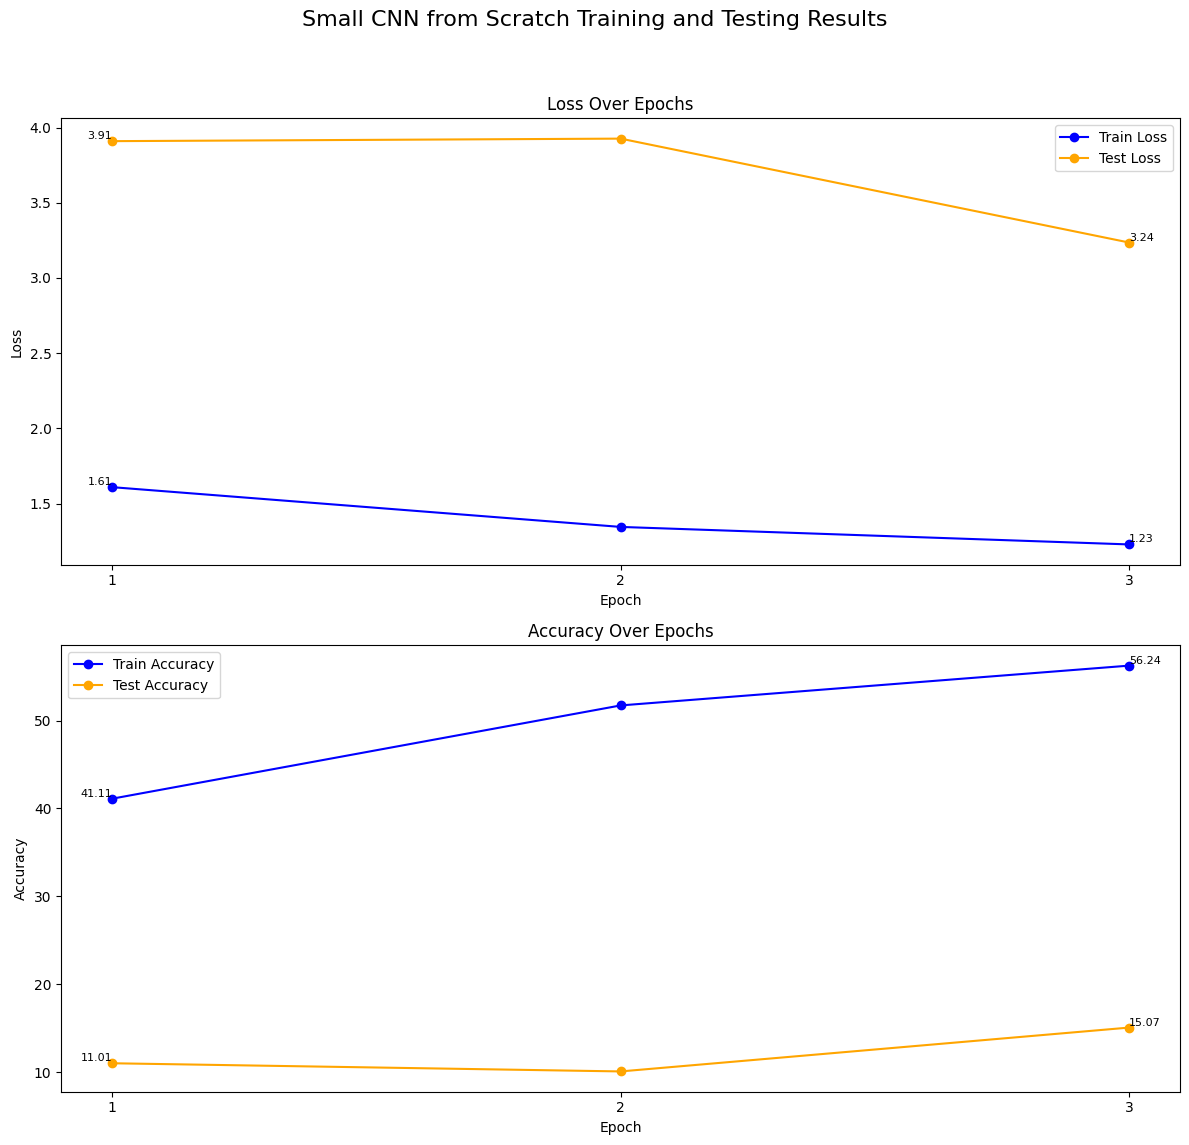

In [15]:
# Create figure for the 2 subplots
fig, axs = plt.subplots(2, figsize=(12, 12))

# Setup figure / plots
fig.suptitle("Small CNN from Scratch Training and Testing Results", fontsize=16)
axs[0].set_title("Loss Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_xticks(range(1, len(smallCnnResults) + 1))
axs[1].set_title("Accuracy Over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(range(1, len(smallCnnResults) + 1))

# Combine all data
trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []
for epochIndex, epochResults in enumerate(smallCnnResults):
	trainLosses.append(epochResults['train']['loss'])
	trainAccuracies.append(epochResults['train']['accuracy'])
	testLosses.append(epochResults['test']['loss'])
	testAccuracies.append(epochResults['test']['accuracy'])

# Plot all data
axs[0].plot(range(1, len(smallCnnResults) + 1), trainLosses, label="Train Loss", marker='o', color='blue')
axs[0].plot(range(1, len(smallCnnResults) + 1), testLosses, label="Test Loss", marker='o', color='orange')
axs[1].plot(range(1, len(smallCnnResults) + 1), trainAccuracies, label="Train Accuracy", marker='o', color='blue')
axs[1].plot(range(1, len(smallCnnResults) + 1), testAccuracies, label="Test Accuracy", marker='o', color='orange')
axs[0].legend()
axs[1].legend()

# Find the beginning and end of each line (first and last epoch) and add text
for ax in axs:
	for line in ax.get_lines():
		xData = line.get_xdata()
		yData = line.get_ydata()
		ax.text(xData[0], yData[0], f"{yData[0]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='right')
		ax.text(xData[-1], yData[-1], f"{yData[-1]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# Get the final epoch's confusion matrix
finalConfusionMatrix = smallCnnResults[-1]['test']['confusion_matrix']
print("Final Epoch Confusion Matrix:")
print(finalConfusionMatrix)

KeyError: 'confusion_matrix'

## Task 2: Improved CNN From Scratch

This section will implement and train an improved CNN on CIFAR-10 with skip connections.

### Task 2: Residual Block Definition

This section will implement a new Residual Block to replace the Sequential Blocks from the simple CNN.

In [ ]:
class ResidualBlock(torch.nn.Module):
	'''
	# Residual Block Definition

	The residual block provides a main path and a skip connection path with projection.
	'''

	def __init__(self, inputChannels: int, outputChannels: int, convolutionalKernelSize: int = 3, paddingSize: int = 1):
		'''
		## Residual Block Initialization

		Initialize the residual block with main and skip paths.
		'''
		super().__init__()

		# Define the main path through the block (same as Sequential Block before)
		self.mainPath = torch.nn.Sequential(

			# Add the convolutional layer with specified kernel
			torch.nn.Conv2d(
				in_channels=inputChannels,
				out_channels=outputChannels,
				kernel_size=convolutionalKernelSize,
				padding=paddingSize
			),

			# Add a batch normalization layer
			torch.nn.BatchNorm2d(
				num_features=outputChannels
			),

			# Add ReLU activation layer
			torch.nn.ReLU(),

			# Add max pooling layer
			torch.nn.MaxPool2d(
				kernel_size=2, 
				stride=2
			)
		)

		# Define the skip connection path (always projection)
		self.skipPath = torch.nn.Sequential(

			# 1x1 convolution to match channels
			torch.nn.Conv2d(
				in_channels=inputChannels,
				out_channels=outputChannels,
				kernel_size=1
			),

			# Batch normalization
			torch.nn.BatchNorm2d(
				num_features=outputChannels
			),

			# Max pooling to match spatial dimensions
			torch.nn.MaxPool2d(
				kernel_size=2,
				stride=2
			)
		)

		# Define final ReLU activation after addition
		self.finalActivation = torch.nn.ReLU()

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		'''
		## Residual Block Forward Pass

		Complete a forward pass through the block, including both main and skip paths.

		Parameters:
			x (torch.Tensor): An input tensor to pass through

		Returns:
			torch.Tensor: The output tensor after passing through the residual block
		'''

		# Pass through main path
		mainOutput = self.mainPath(x)

		# Pass through skip path
		skipOutput = self.skipPath(x)

		# Add the two outputs
		output = mainOutput + skipOutput

		# Pass through final activation
		activated = self.finalActivation(output)

		return activated

### Task 2: Improved CNN Model Implementation

This section will create a CNN model for use in task 2.

In [ ]:
class ImprovedCnnFromScratch(torch.nn.Module):

	def __init__(self, numClasses: int = 10, numConvolutionalBlocks: int = 3, convolutionalKernelSize: int = 3, doPrintSummary: bool = True):
		'''
		## CNN Initialiation

		Initialize the CNN model with the specified parameters.

		Parameters:
			numClasses (int): The number of output classes for classification
			numConvolutionalBlocks (int): The number of convolutional blocks to include in the model
			convolutionalKernelSize (int): The kernel size to use for all convolutional layers

		Note:
			- The model assumes that each block is the same structure with Conv2D -> BatchNorm2D -> ReLU -> MaxPool2D
		'''
		super().__init__()

		# Save all init params
		self.numClasses = numClasses
		self.numConvolutionalBlocks = numConvolutionalBlocks
		self.convolutionalKernelSize = convolutionalKernelSize

		# Calculate padding based on kernel size for same-style
		if convolutionalKernelSize % 2 == 0:
			raise ValueError("Convolutional kernel size must be odd for 'same' padding!")
		paddingSize = convolutionalKernelSize // 2
		if paddingSize < 1:
			raise ValueError("Convolutional kernel size too small for 'same' padding!")

		# Add layers depending on number of blocks desired
		self.convolutionalBlocks = torch.nn.ModuleList()
		for i in range(numConvolutionalBlocks):

			# Compute input and output for the convolutional layer at this block
			inputChannels = 3 if i == 0 else 16 * (2 ** (i - 1))
			outputChannels = 16 * (2 ** i)

			# Add residual block to list
			self.convolutionalBlocks.append(
				ResidualBlock(
					inputChannels=inputChannels,
					outputChannels=outputChannels,
					convolutionalKernelSize=convolutionalKernelSize,
					paddingSize=paddingSize
				)
			)
			
		# Determine flattened size after convolutions and pooling by using a dummy pass with cifar-10 size
		with torch.no_grad():
			dummyX = torch.zeros(1, 3, 32, 32)
			for block in self.convolutionalBlocks:
				dummyX = block(dummyX)
		finalFlattenedSize = dummyX.numel()

		# Define fully connected layer
		self.fullyConnectedLayer = torch.nn.Linear(in_features=finalFlattenedSize, out_features=10)

		# Print model summary if desired
		if doPrintSummary:
			totalParameters, _ = self.countAllParameters()
			print(f"Small CNN Model Initialized:")
			print(f"-> Number of Convolutional Blocks: {self.numConvolutionalBlocks}")
			print(f"-> Convolutional Kernel Size: {self.convolutionalKernelSize}")
			print(f"-> Total Trainable Parameters: {totalParameters}")

	# Define a forward pass through the CNN blocks
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		'''
		## Model Forward Pass

		Parameters:
			x (torch.Tensor): An input tensor to pass through

		Returns:
			torch.Tensor: The output tensor after passing through the model
		'''

		# Pass through each convolutional block
		for block in self.convolutionalBlocks:
			x = block(x)

		# Flatten the output
		x = torch.flatten(input=x, start_dim=1)

		# Pass through the fully connected layer
		x = self.fullyConnectedLayer(x)

		return x
	
	def countAllParameters(self) -> tuple:
		'''
		## Count All Trainable Parameters

		Count all of the trainable parameters in the model.

		Returns:
			tuple: A tuple like (total model parameters, [per-layer parameter counts])
		'''

		allParamCount = sum(param.numel() for param in self.parameters() if param.requires_grad)
		perLayerParamCounts = [param.numel() for param in self.parameters() if param.requires_grad]
		return allParamCount, perLayerParamCounts

### Task 2: CNN Model Training

This section will train the improved CNN for task 1 on the CIFAR-10 dataset.

In [ ]:
# Check if we are continuing from previous run
improvedCnnInfo = loadResultsFromFile("improved_cnn_results")
if improvedCnnInfo is None:

	# Instantiate the CNN model
	model = ImprovedCnnFromScratch(numClasses=10, 
								numConvolutionalBlocks=3, 
								convolutionalKernelSize=3, 
								doPrintSummary=True
	)

	# Create the model handler
	modelHandler = CnnModelHandler(model=model, 
								trainDataLoader=trainDataLoader, 
								testDataLoader=testDataLoader
	)

	# Train and test the model for 25 epochs
	startTime = time.time()
	improvedCnnResults = modelHandler.doModelRun(numEpochs=25)
	improvedCnnTotalTime = time.time() - startTime
	print(f"Total Training and Testing Time for Improved CNN: {improvedCnnTotalTime/60:.2f} minutes")

	# Save the parameter count
	improvedCnnParamCountTotal, improvedCnnParamCountPerLayer = model.countAllParameters()

	# Make info object and save to json
	improvedCnnInfo = {
		'results': improvedCnnResults,
		'param_count_total': improvedCnnParamCountTotal,
		'param_count_per_layer': improvedCnnParamCountPerLayer,
		'total_time_seconds': improvedCnnTotalTime
	}
	saveResultsToFile(improvedCnnInfo, "improved_cnn_results")

	# Clean up memory
	del model, modelHandler
	cleanupCpuAndGpu()

# If we are continuing, then bring out all the data
else:
	improvedCnnResults = improvedCnnInfo.get('results', [])
	improvedCnnParamCountTotal = improvedCnnInfo.get('param_count_total', None)
	improvedCnnParamCountPerLayer = improvedCnnInfo.get('param_count_per_layer', None)
	improvedCnnTotalTime = improvedCnnInfo.get('total_time_seconds', None)

### Task 2: Results Display

This section will display the results for task 2 with the above CNN execution.

In [ ]:
# Create figure for the 2 subplots
fig, axs = plt.subplots(2, figsize=(12, 12))

# Setup figure / plots
fig.suptitle("Improved CNN from Scratch Training and Testing Results", fontsize=16)
axs[0].set_title("Loss Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_xticks(range(1, len(improvedCnnResults) + 1))
axs[1].set_title("Accuracy Over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(range(1, len(improvedCnnResults) + 1))

# Combine all data
trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []
for epochIndex, epochResults in enumerate(improvedCnnResults):
	trainLosses.append(epochResults['train']['loss'])
	trainAccuracies.append(epochResults['train']['accuracy'])
	testLosses.append(epochResults['test']['loss'])
	testAccuracies.append(epochResults['test']['accuracy'])

# Plot all data
axs[0].plot(range(1, len(improvedCnnResults) + 1), trainLosses, label="Train Loss", marker='o', color='green')
axs[0].plot(range(1, len(improvedCnnResults) + 1), testLosses, label="Test Loss", marker='o', color='purple')
axs[1].plot(range(1, len(improvedCnnResults) + 1), trainAccuracies, label="Train Accuracy", marker='o', color='green')
axs[1].plot(range(1, len(improvedCnnResults) + 1), testAccuracies, label="Test Accuracy", marker='o', color='purple')
axs[0].legend()
axs[1].legend()

# Find the beginning and end of each line (first and last epoch) and add text
for ax in axs:
	for line in ax.get_lines():
		xData = line.get_xdata()
		yData = line.get_ydata()
		ax.text(xData[0], yData[0], f"{yData[0]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='right')
		ax.text(xData[-1], yData[-1], f"{yData[-1]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Get the final epoch's confusion matrix
finalConfusionMatrix = improvedCnnResults[-1]['test']['confusion_matrix']
print("Final Epoch Confusion Matrix:")
print(finalConfusionMatrix)

### Task 2: Simple vs Improved CNN Comparison

This section will provide a comparison between the two CNN's.

In [ ]:
# Create figure for the 2 subplots
fig, axs = plt.subplots(2, figsize=(12, 12))

# Setup figure / plots
fig.suptitle("Simple vs Improved CNN Comparison", fontsize=16)
axs[0].set_title("Loss Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_xticks(range(1, len(improvedCnnResults) + 1))
axs[1].set_title("Accuracy Over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(range(1, len(improvedCnnResults) + 1))

# Combine all data
trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []
for epochIndex, epochResults in enumerate(smallCnnResults):
	trainLosses.append(epochResults['train']['loss'])
	trainAccuracies.append(epochResults['train']['accuracy'])
	testLosses.append(epochResults['test']['loss'])
	testAccuracies.append(epochResults['test']['accuracy'])

# Plot all data
axs[0].plot(range(1, len(smallCnnResults) + 1), trainLosses, label="Small CNN Train Loss", marker='o', color='blue')
axs[0].plot(range(1, len(smallCnnResults) + 1), testLosses, label="Small CNN Test Loss", marker='o', color='orange')
axs[1].plot(range(1, len(smallCnnResults) + 1), trainAccuracies, label="Small CNN Train Accuracy", marker='o', color='blue')
axs[1].plot(range(1, len(smallCnnResults) + 1), testAccuracies, label="Small CNN Test Accuracy", marker='o', color='orange')
axs[0].legend()
axs[1].legend()

# Combine all data
trainLosses = []
trainAccuracies = []
testLosses = []
testAccuracies = []
for epochIndex, epochResults in enumerate(improvedCnnResults):
	trainLosses.append(epochResults['train']['loss'])
	trainAccuracies.append(epochResults['train']['accuracy'])
	testLosses.append(epochResults['test']['loss'])
	testAccuracies.append(epochResults['test']['accuracy'])

# Plot all data
axs[0].plot(range(1, len(improvedCnnResults) + 1), trainLosses, label="Improved CNN Train Loss", marker='o', color='green')
axs[0].plot(range(1, len(improvedCnnResults) + 1), testLosses, label="Improved CNN Test Loss", marker='o', color='purple')
axs[1].plot(range(1, len(improvedCnnResults) + 1), trainAccuracies, label="Improved CNN Train Accuracy", marker='o', color='green')
axs[1].plot(range(1, len(improvedCnnResults) + 1), testAccuracies, label="Improved CNN Test Accuracy", marker='o', color='purple')
axs[0].legend()
axs[1].legend()

# Find the beginning and end of each line (first and last epoch) and add text
for ax in axs:
	for line in ax.get_lines():
		xData = line.get_xdata()
		yData = line.get_ydata()
		ax.text(xData[0], yData[0], f"{yData[0]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='right')
		ax.text(xData[-1], yData[-1], f"{yData[-1]:.2f}", fontsize=8, verticalalignment='bottom', horizontalalignment='left')

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()